<a href="https://colab.research.google.com/github/lwerth/ECE-Final/blob/master/HAN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Proppy Propaganda Classifier - HAN
This script uses news articles pulled from a news corpus provided by https://propaganda.qcri.org/ in hopes of building a prapaganda classifier. Each article is annotated with "propoganistic" and "non-propoganistic" lables that will help with classification of each article. We exploit these labels to train a model with minimal external classification.

Let's begin:

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]
        

In [350]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [351]:
%cd /content/drive
!ls


/content/drive
'My Drive'


In [0]:
train_df = pd.read_pickle(r'My Drive/Spring 2020/ECE 523 - Machine Learning/ECE_523_FP/proppy_1.0.train.pkl')
val_df = pd.read_pickle(r'My Drive/Spring 2020/ECE 523 - Machine Learning/ECE_523_FP/proppy_1.0.dev.pkl')
test_df = pd.read_pickle(r'My Drive/Spring 2020/ECE 523 - Machine Learning/ECE_523_FP/proppy_1.0.test.pkl')

In [353]:
train_df.tail()

,article_text,event_location,average_tone,article_date,article_ID,article_URL_direct,MBFC_factuality_label_source,article_url,MBFC_factuality_label,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
35988,From The Telegraph: Towns in Brazil have beco...,"Hollywood, California, United States",-3.19327731092437,2018-09-10,785781276,https://www.lewrockwell.com/2018/09/no_author/...,N/A,Escape to Boa Vista,unknown,unknown,lewrockwell.com,unknown,unknown,lewrockwell.com,1
35989,The second episode of Consortium News on Flash...,"Pacifica, California, United States",0.52631578947369,2018-09-10,785781322,https://www.lewrockwell.com/2018/09/no_author/...,Jim Macgregor,Flash Points,unknown,unknown,lewrockwell.com,unknown,unknown,lewrockwell.com,1
35990,"It is beginning. Actually, it’s been happenin...","White House, District of Columbia, United States",-3.45528455284552,2018-09-10,785781455,https://www.lewrockwell.com/2018/09/eric-peter...,Eric Peters,Tesla’s Death Dive,unknown,unknown,lewrockwell.com,unknown,unknown,lewrockwell.com,1
35991,Justin’s note: As regular Dispatch readers kno...,United States,-1.05204872646734,2018-09-10,785781711,https://www.lewrockwell.com/2018/09/doug-casey...,Doug Casey,Doug Casey on the ‘Politically Correct’ Movement,unknown,unknown,lewrockwell.com,unknown,unknown,lewrockwell.com,1
35992,“No man can serve two masters” (Matthew 6:24)....,United States,0.25641025641026,2018-09-11,786060460,https://www.lewrockwell.com/2018/09/laurence-m...,Laurence M. Vance,Serving Two Masters,unknown,unknown,lewrockwell.com,unknown,unknown,lewrockwell.com,1


In [354]:
train_df.propaganda_label.unique()

array([-1,  1])

In [355]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35993 entries, 0 to 35992
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_text                  35993 non-null  object
 1   event_location                35993 non-null  object
 2   average_tone                  35993 non-null  object
 3   article_date                  35993 non-null  object
 4   article_ID                    35993 non-null  object
 5   article_URL_direct            35993 non-null  object
 6   MBFC_factuality_label_source  35993 non-null  object
 7   article_url                   35993 non-null  object
 8   MBFC_factuality_label         35993 non-null  object
 9   URL_to_MBFC_page              35993 non-null  object
 10  source_name                   35993 non-null  object
 11  MBFC_notes_about_source       35993 non-null  object
 12  MBFC_bias_label               35993 non-null  object
 13  source_URL      

Now we can look at how many articles are labeled 'propaganstic', 1,  and 'non-propaganistic', -1. -The bias labels have 35 types of bias categories, unknown being one of them which is categorized as non-propaganistic. This is helpful in understanding why there are significantly larger numbers of non-propaganistic labels over propagandistic.  

In [356]:
grouped = train_df.groupby('propaganda_label')
print("total categories:", grouped.ngroups)
print(grouped.size())

total categories: 2
propaganda_label
-1    31972
 1     4021
dtype: int64


In [0]:
#clean the text  to remove puntuation and unessesary spaces

import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
paras = []
labels = []
texts = []

In [359]:
import nltk
nltk.download('punkt')

sent_lens = []
sent_nums = []
for idx in range(train_df.article_text.shape[0]):
    text = clean_str(train_df.article_text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


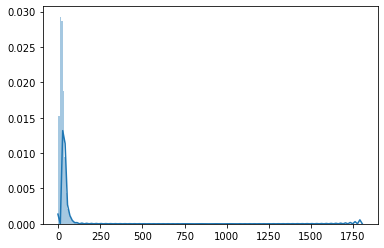

In [360]:
sns.distplot(sent_lens, bins=200)
plt.show()

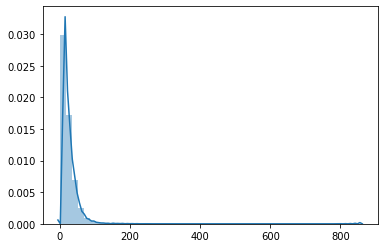

In [361]:
sns.distplot(sent_nums)
plt.show()

In [0]:
max_features=200000
max_senten_len=50
max_senten_num=10
embed_size=100
VALIDATION_SPLIT = 0.2

In [0]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [0]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [365]:
data.shape


(35993, 10, 50)

In [0]:
lbl = train_df['propaganda_label']
text = train_df['article_text']

In [367]:

cates = train_df.groupby('propaganda_label')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 2
propaganda_label
-1    31972
 1     4021
dtype: int64


In [0]:
labels = pd.get_dummies(lbl)


In [369]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (35993, 10, 50)
Shape of labels tensor: (35993, 2)


In [370]:
val_df.head()

,article_text,event_location,average_tone,article_date,article_ID,article_URL_direct,MBFC_factuality_label_source,article_url,MBFC_factuality_label,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
0,Convened to examine the causes of civil unrest...,"Chicago, Illinois, United States",-4.59363957597174,2018-02-27,734202079,http://www.courant.com/nation-world/ct-no-prog...,Tracy Jan,Report: No progress for African-Americans on h...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
1,Discriminating against someone on the basis of...,"Chicago, Illinois, United States",-1.56695156695157,2018-02-27,734203497,http://www.courant.com/nation-world/ct-anti-di...,Matt Zapotosky,Employers can't discriminate based on sexual o...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
2,"Bill Cosby's 44-year-old daughter, Ensa Cosby,...","Philadelphia, Pennsylvania, United States",-6.15065976908082,2018-02-27,734204589,http://www.courant.com/entertainment/ct-cosby-...,Bob Salsberg,"Bill Cosby's daughter Ensa, 44, dies in Massac...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
3,"The fast-moving, powerful theatrical locomotiv...","New York, United States",1.52439024390244,2018-02-27,734213466,http://www.courant.com/entertainment/arts-thea...,Christopher Arnott,"'Murder On The Orient Express' A Funny, Fast-P...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
4,It's Friday. It's National Pizza Day. Grab lif...,"West Hartford, Connecticut, United States",1.19760479041916,2018-02-09,729554384,http://www.courant.com/features/food/hc-nation...,Nicholas Rondinone,You Can Celebrate National Pizza Day Right Here,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1


In [371]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data
y_train = labels
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of propaganistic and non-propaganistic reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of propaganistic and non-propaganistic reviews in traing and validation set
[-1, 1]
[31972, 4021]
[6390, 808]


In [372]:
val_df = val_df.rename(columns={"propaganda_label": "propaganda_label_v", "article_text" : "article_text_v"})
val_df.head()

,article_text_v,event_location,average_tone,article_date,article_ID,article_URL_direct,MBFC_factuality_label_source,article_url,MBFC_factuality_label,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label_v
0,Convened to examine the causes of civil unrest...,"Chicago, Illinois, United States",-4.59363957597174,2018-02-27,734202079,http://www.courant.com/nation-world/ct-no-prog...,Tracy Jan,Report: No progress for African-Americans on h...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
1,Discriminating against someone on the basis of...,"Chicago, Illinois, United States",-1.56695156695157,2018-02-27,734203497,http://www.courant.com/nation-world/ct-anti-di...,Matt Zapotosky,Employers can't discriminate based on sexual o...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
2,"Bill Cosby's 44-year-old daughter, Ensa Cosby,...","Philadelphia, Pennsylvania, United States",-6.15065976908082,2018-02-27,734204589,http://www.courant.com/entertainment/ct-cosby-...,Bob Salsberg,"Bill Cosby's daughter Ensa, 44, dies in Massac...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
3,"The fast-moving, powerful theatrical locomotiv...","New York, United States",1.52439024390244,2018-02-27,734213466,http://www.courant.com/entertainment/arts-thea...,Christopher Arnott,"'Murder On The Orient Express' A Funny, Fast-P...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
4,It's Friday. It's National Pizza Day. Grab lif...,"West Hartford, Connecticut, United States",1.19760479041916,2018-02-09,729554384,http://www.courant.com/features/food/hc-nation...,Nicholas Rondinone,You Can Celebrate National Pizza Day Right Here,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1


We do the same to the val and test data to make sure the format of the data is consistent throughout.

In [373]:
val_df.propaganda_label_v.unique()

array([-1,  1])

In [374]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5139 entries, 0 to 5138
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_text_v                5139 non-null   object
 1   event_location                5139 non-null   object
 2   average_tone                  5139 non-null   object
 3   article_date                  5139 non-null   object
 4   article_ID                    5139 non-null   object
 5   article_URL_direct            5139 non-null   object
 6   MBFC_factuality_label_source  5139 non-null   object
 7   article_url                   5139 non-null   object
 8   MBFC_factuality_label         5139 non-null   object
 9   URL_to_MBFC_page              5139 non-null   object
 10  source_name                   5139 non-null   object
 11  MBFC_notes_about_source       5139 non-null   object
 12  MBFC_bias_label               5139 non-null   object
 13  source_URL        

In [0]:
lbl_v = val_df['propaganda_label_v']
text_v = val_df['article_text_v']

Now we can look at how many articles are labeled 'propaganstic', 1,  and 'non-propaganistic', -1. -The bias labels have 35 types of bias categories, unknown being one of them which is categorized as non-propaganistic. This is helpful in understanding why there are significantly larger numbers of non-propaganistic labels over propagandistic.  

In [376]:
groupedv = val_df.groupby('propaganda_label_v')
print("total categories:", groupedv.ngroups)
print(groupedv.size())

total categories: 2
propaganda_label_v
-1    4564
 1     575
dtype: int64


In [0]:
#clean the text  to remove puntuation and unessesary spaces

import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
paras_V = []
labels_V = []
texts_V = []

In [0]:
vsent_lens = []
vsent_nums = []
for idx in range(val_df.article_text_v.shape[0]):
    text_v = clean_str(val_df.article_text_v[idx])
    texts_V.append(text_v)
    sentences_v = tokenize.sent_tokenize(text_v)
    vsent_nums.append(len(sentences_v))
    for sentv in sentences_v:
        vsent_lens.append(len(text_to_word_sequence(sentv)))
    paras_V.append(sentences_v)

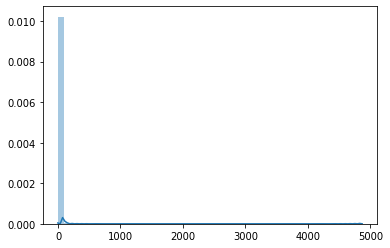

In [380]:
sns.distplot(vsent_lens, bins=50)
plt.show()

Below is a micro-view of the sentence length

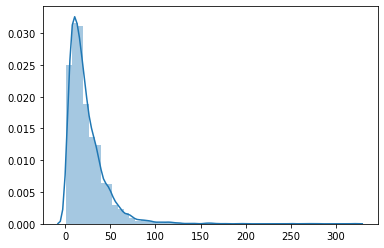

In [381]:
sns.distplot(vsent_nums)
plt.show()

In [0]:
tokenizerv = Tokenizer(num_words=max_features, oov_token=True)
tokenizerv.fit_on_texts(texts_V)

In [0]:
vdata = np.zeros((len(texts_V), max_senten_num, max_senten_len), dtype='int32')
for i, sentences_v in enumerate(paras_V):
    for j, sent_v in enumerate(sentences_v):
        if j< max_senten_num:
            wordTokens_v = text_to_word_sequence(sent_v)
            k=0
            for _, word_v in enumerate(wordTokens_v):
                try:
                    if k<max_senten_len and tokenizerv.word_index[word_v]<max_features:
                        data[i,j,k] = tokenizerv.word_index[word_v]
                        k=k+1
                except:
                    print(word_v)
                    pass

In [384]:
vdata.shape

(5139, 10, 50)

In [385]:
word_indexv = tokenizerv.word_index
print('Total %s unique tokens.' % len(word_indexv))

Total 83644 unique tokens.


In [0]:
labels_V = pd.get_dummies(lbl_v)

In [387]:
print('Shape of data tensor:', vdata.shape)
print('Shape of labels tensor:', labels_V.shape)

Shape of data tensor: (5139, 10, 50)
Shape of labels tensor: (5139, 2)


In [0]:
indices = np.arange(vdata.shape[0])
np.random.shuffle(indices)
vdata = vdata[indices]
labels_V = labels_V.iloc[indices]
#vnb_validation_samples = int(VALIDATION_SPLIT * vdata.shape[0])

#x_train = data
#y_train = labels
#x_val = vdata
#y_val = labels_V
# x_test = tdata
# y_test = labels_y
#print('Number of propaganistic and nonpropaganistic reviews in traing and validation set')
#print(y_train.columns.tolist())
#print(y_train.sum(axis=0).tolist())
#print(y_val.sum(axis=0).tolist())
# print(y_test.sum(axis=0).tolist())

No we format the test dataset

In [389]:
test_df.propaganda_label.unique()

array([-1,  1])

In [390]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10162 entries, 0 to 10161
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_text                  10162 non-null  object
 1   event_location                10162 non-null  object
 2   average_tone                  10162 non-null  object
 3   article_date                  10162 non-null  object
 4   article_ID                    10162 non-null  object
 5   article_URL_direct            10162 non-null  object
 6   MBFC_factuality_label_source  10162 non-null  object
 7   article_url                   10162 non-null  object
 8   MBFC_factuality_label         10162 non-null  object
 9   URL_to_MBFC_page              10162 non-null  object
 10  source_name                   10162 non-null  object
 11  MBFC_notes_about_source       10162 non-null  object
 12  MBFC_bias_label               10162 non-null  object
 13  source_URL      

In [391]:
test_df = test_df.rename(columns={"propaganda_label": "propaganda_label_t", "article_text" : "article_text_t"})
test_df.head()

,article_text_t,event_location,average_tone,article_date,article_ID,article_URL_direct,MBFC_factuality_label_source,article_url,MBFC_factuality_label,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label_t
0,Eat in Connecticut teamed up with End Hunger C...,"Shiraz, Fars, Iran",0.78125,2018-02-05,728352356,http://www.courant.com/community/west-hartford...,Dennis Hohenberger,Pub Crawl Benefits End Hunger Connecticut,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
1,Owners of an old Pennsylvania power plant that...,"Brunner Island, Pennsylvania, United States",-1.61579892280072,2018-02-15,730955196,http://www.courant.com/politics/hc-pol-brunner...,Gregory B. Hladky,Sierra Club Reaches Deal On Plant Polluting Co...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
2,The majority owner of President Donald Trump's...,"Manhattan, New York, United States",-4.177545691906,2018-02-25,733772812,http://www.courant.com/nation-world/ct-trump-p...,Ana Cerrud,"Police, yelling, power turned off: Confrontati...",HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
3,Connecticut’s most likely option for using tol...,"Connecticut, United States",-7.20081135902637,2018-01-04,727857752,http://www.courant.com/politics/hc-pol-toll-co...,Gregory B. Hladky,'Congestion Pricing' Is A Likely Option If Con...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1
4,Escaped prisoner Jerry Mercado is back in Conn...,"Georgia, United States",-6.53409090909091,2018-02-03,727792592,http://www.courant.com/breaking-news/hc-prison...,David Owens,Escaped Prisoner Jerry Mercado Back In Connect...,HIGH,http://mediabiasfactcheck.com/the-hartford-cou...,The Hartford Courant,The Hartford Courant is the largest daily news...,leftcenter06,courant.com,-1


In [0]:
lbl_t = test_df['propaganda_label_t']
text_t = test_df['article_text_t']

Now we can look at how many articles are labeled 'propaganstic', 1,  and 'non-propaganistic', -1. -The bias labels have 35 types of bias categories, unknown being one of them which is categorized as non-propaganistic. This is helpful in understanding why there are significantly larger numbers of non-propaganistic labels over propagandistic.  

In [393]:
groupedt = test_df.groupby('propaganda_label_t')
print("total categories:", groupedt.ngroups)
print(groupedt.size())

total categories: 2
propaganda_label_t
-1    9021
 1    1141
dtype: int64


In [0]:
#clean the text  to remove puntuation and unessesary spaces

import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
paras_t = []
labels_t = []
texts_t = []

In [0]:
sent_lens_t = []
sent_nums_t = []
for idx in range(test_df.article_text_t.shape[0]):
    textt = clean_str(test_df.article_text_t[idx])
    texts_t.append(textt)
    sentences_t = tokenize.sent_tokenize(textt)
    sent_nums_t.append(len(sentences_t))
    for sentt in sentences_t:
        sent_lens_t.append(len(text_to_word_sequence(sentt)))
    paras_t.append(sentences_t)

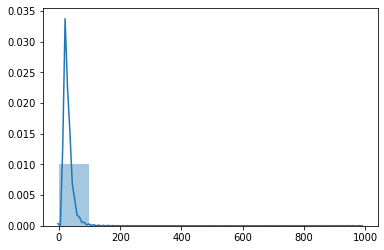

In [397]:
sns.distplot(sent_lens_t, bins=10)
plt.show()

Below is a micro-view of the sentence length

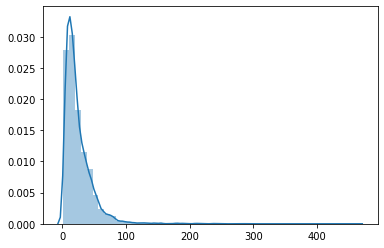

In [398]:
sns.distplot(sent_nums_t)
plt.show()

In [0]:
tokenizert = Tokenizer(num_words=max_features, oov_token=True)
tokenizert.fit_on_texts(texts_t)

In [0]:
tdata = np.zeros((len(texts_t), max_senten_num, max_senten_len), dtype='int32')
for i, sentences_t in enumerate(paras_t):
    for j, sentt in enumerate(sentences_t):
        if j< max_senten_num:
            wordTokenst = text_to_word_sequence(sentt)
            k=0
            for _, wordt in enumerate(wordTokenst):
                try:
                    if k<max_senten_len and tokenizert.word_index[wordt]<max_features:
                        data[i,j,k] = tokenizert.word_index[wordt]
                        k=k+1
                except:
                    print(wordt)
                    pass

In [401]:
tdata.shape

(10162, 10, 50)

In [402]:
word_indext = tokenizert.word_index
print('Total %s unique tokens.' % len(word_indext))

Total 120703 unique tokens.


In [0]:
labels_t = pd.get_dummies(lbl_t)


In [404]:
print('Shape of data tensor:', tdata.shape)
print('Shape of labels tensor:', labels_t.shape)

Shape of data tensor: (10162, 10, 50)
Shape of labels tensor: (10162, 2)


In [405]:
indices = np.arange(tdata.shape[0])
np.random.shuffle(indices)
tdata = tdata[indices]
labels_t = labels_t.iloc[indices]
tnb_validation_samples = int(VALIDATION_SPLIT * tdata.shape[0])

x_train = data
y_train = labels
x_val = vdata
y_val = labels_V
x_test = tdata
y_test = labels_t
print('Number of propagandistic and nonpropagandistic labels in traing, validation, and testing set')
print('labels: ', y_train.columns.tolist())
print('training:', y_train.sum(axis=0).tolist())
print('validation:', y_val.sum(axis=0).tolist())
print('testing:', y_test.sum(axis=0).tolist())

Number of propagandistic and nonpropagandistic labels in traing, validation, and testing set
labels:  [-1, 1]
training: [31972, 4021]
validation: [4564, 575]
testing: [9021, 1141]


Now we can potentially work with the model!!

In [0]:
import os


In [0]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("My Drive/Spring 2020/ECE 523 - Machine Learning/ECE_523_FP-(1)/glove.6B.zip", 'r')
zip_ref.extractall("/tmp")
#zip_ref.close()

In [408]:
GLOVE_DIR = "My Drive/Spring 2020/ECE 523 - Machine Learning/ECE_523_FP-(1)/glove/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [409]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 46575 which is 38.59 % of total words


In [0]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)


In [0]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)


In [412]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

TypeError: ignored